## Importing libs

In [0]:
COLAB = True # NOTE change me :D

In [0]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline
sns.set() # apply the seaborn defaults to plotted figures (e.g. theme, scaling, color palette), instead of matplotlib's

In [9]:
if COLAB:
  try:
    # Colab only
    %tensorflow_version 2.x
  except Exception:
      pass

TensorFlow 2.x selected.


In [10]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.0.0


In [0]:
import warnings
from time import time, strftime

In [12]:
strftime('%X')

'13:23:43'

## Preparing the Fashion-MNIST dataset
[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of Zalando’s article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image, associated with a label from 10 classes.

**NOTE:** you should have the .csv files in the directory listed below

In [13]:
# confirm that you have fashion-mnist_train.csv and fashion-mnist_test.csv (unzipped)
!ls ../fashion-mnist-dataset/

ls: cannot access '../fashion-mnist-dataset/': No such file or directory


In [0]:
if not COLAB:
  PATH_TO_DATA = os.path.join("..", "fashion-mnist-dataset")

  # the datasets have the label on the first column and the image pixels on the following 784
  train_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_train.csv"), delimiter=',')
  test_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_test.csv"), delimiter=',')

In [15]:
if COLAB:
  # NOTE run me on Colab instead
  fashion_mnist = keras.datasets.fashion_mnist
  (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

  train_images = train_images.reshape((60000, -1))
  test_images = test_images.reshape((10000, -1))

  train_dataset_csv = np.concatenate((train_labels.reshape(60000, 1), train_images), axis=1)
  test_dataset_csv = np.concatenate((test_labels.reshape(10000, 1), test_images), axis=1)

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
IMG_WIDTH = IMG_HEIGHT = 28
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH) # grayscale images
IMG_FLAT_SHAPE = (IMG_HEIGHT*IMG_WIDTH, )

CLASS_NAME = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
CLASS_COUNT = len(CLASS_NAME)

## Split train into train + validation

In [0]:
# random seed for splitting the data deterministically
RANDOM_SEED = 886
np.random.seed(RANDOM_SEED)

In [18]:
from sklearn.model_selection import train_test_split

train_dataset, validation_dataset = train_test_split(train_dataset_csv, train_size=0.8, shuffle=True, random_state=RANDOM_SEED)
print(f"train:      {train_dataset.shape}") # 80%
print(f"validation: {validation_dataset.shape}") # 20%

test_dataset = test_dataset_csv
print(f"test:       {test_dataset.shape}")

train:      (48000, 785)
validation: (12000, 785)
test:       (10000, 785)


## Separate labels and images

In [0]:
if not COLAB:
  ys_train = train_dataset["label"].values
  ys_val   = validation_dataset["label"].values
  ys_test  = test_dataset["label"].values

  print(ys_train.shape, "min:", ys_train.min(), "max:", ys_train.max())
  print(ys_val.shape,   "min:", ys_val.min(),   "max:", ys_val.max())
  print(ys_test.shape,  "min:", ys_test.min(),  "max:", ys_test.max())

In [20]:
if COLAB:
  # NOTE run me on Colab instead
  ys_train = train_dataset[:, 0]
  ys_val   = validation_dataset[:, 0]
  ys_test  = test_dataset[:, 0]

  print(ys_train.shape, "min:", ys_train.min(), "max:", ys_train.max())
  print(ys_val.shape,   "min:", ys_val.min(),   "max:", ys_val.max())
  print(ys_test.shape,  "min:", ys_test.min(),  "max:", ys_test.max())

(48000,) min: 0 max: 9
(12000,) min: 0 max: 9
(10000,) min: 0 max: 9


In [0]:
if not COLAB:
  xs_train = train_dataset.loc[:, train_dataset.columns != "label"].values
  xs_val   = validation_dataset.loc[:, validation_dataset.columns != "label"].values
  xs_test  = test_dataset.loc[:, test_dataset.columns != "label"].values

  print(xs_train.shape, "min:", xs_train.min(), "max:", xs_train.max())
  print(xs_val.shape,   "min:", xs_val.min(),   "max:", xs_val.max())
  print(xs_test.shape,  "min:", xs_test.min(),  "max:", xs_test.max())

In [22]:
if COLAB:
  # NOTE run me on Colab instead
  xs_train = train_dataset[:, 1:]
  xs_val   = validation_dataset[:, 1:]
  xs_test  = test_dataset[:, 1:]

  print(xs_train.shape, "min:", xs_train.min(), "max:", xs_train.max())
  print(xs_val.shape,   "min:", xs_val.min(),   "max:", xs_val.max())
  print(xs_test.shape,  "min:", xs_test.min(),  "max:", xs_test.max())

(48000, 784) min: 0 max: 255
(12000, 784) min: 0 max: 255
(10000, 784) min: 0 max: 255


In [0]:
def each_count(array):
    count = np.bincount(array)
    nonzero_count = np.nonzero(count)[0]
    return zip(nonzero_count, count[nonzero_count])

In [24]:
class_count_train = list(each_count(ys_train))
class_count_val   = list(each_count(ys_val))
class_count_test  = list(each_count(ys_test))
print("              Train         Validation    Test")
for label in range(CLASS_COUNT):
    print(f"{(CLASS_NAME[label] + ':'):<12}  "
          f"{class_count_train[label][1]} ({class_count_train[label][1] / ys_train.shape[0]:.2f}%)  "
          f"{class_count_val[label][1]} ({class_count_val[label][1] / ys_val.shape[0]:.2f}%)  "
          f"{class_count_test[label][1]} ({class_count_test[label][1] / ys_test.shape[0]:.2f}%)")

              Train         Validation    Test
T-shirt/top:  4772 (0.10%)  1228 (0.10%)  1000 (0.10%)
Trouser:      4793 (0.10%)  1207 (0.10%)  1000 (0.10%)
Pullover:     4776 (0.10%)  1224 (0.10%)  1000 (0.10%)
Dress:        4794 (0.10%)  1206 (0.10%)  1000 (0.10%)
Coat:         4804 (0.10%)  1196 (0.10%)  1000 (0.10%)
Sandal:       4820 (0.10%)  1180 (0.10%)  1000 (0.10%)
Shirt:        4824 (0.10%)  1176 (0.10%)  1000 (0.10%)
Sneaker:      4806 (0.10%)  1194 (0.10%)  1000 (0.10%)
Bag:          4797 (0.10%)  1203 (0.10%)  1000 (0.10%)
Ankle boot:   4814 (0.10%)  1186 (0.10%)  1000 (0.10%)


## Normalize images and one-hot encode labels

In [0]:
xs_train = xs_train.astype('float32') / 255.0
xs_val = xs_val.astype('float32') / 255.0
xs_test = xs_test.astype('float32') / 255.0

**Let's forget about the test set for now..** just assume it doesn't exist (but don't worry, we'll come back to it at the end).

In [26]:
print(f"xs_train: mean={xs_train.mean():>8.4f}, stddev={xs_train.std():>7.4f}")

# NOTE that we must use stats from train data to normalize the val and test sets aswell
mean, std = xs_train.mean(), xs_train.std()
X_train = (xs_train - mean) / std

print(f"X_train:  mean={X_train.mean():>8.4f}, stddev={X_train.std():>7.4f}")

xs_train: mean=  0.2857, stddev= 0.3527
X_train:  mean= -0.0000, stddev= 1.0000


In [27]:
X_val = (xs_val - mean) / std
print(f"xs_val: mean={xs_val.mean():>8.4f}, stddev={xs_val.std():>7.4f}")
print(f"X_val:  mean={X_val.mean():>8.4f}, stddev={X_val.std():>7.4f}") # mean should be close to 0 and stddev close to 1

xs_val: mean=  0.2875, stddev= 0.3541
X_val:  mean=  0.0053, stddev= 1.0039


In [0]:
def onehot_encode(ys):
    n_examples, *_ = ys.shape
    onehot = np.zeros(shape=(n_examples, CLASS_COUNT))
    onehot[np.arange(n_examples), ys] = 1
    return onehot

In [29]:
Y_train = onehot_encode(ys_train)
print(ys_train.shape, Y_train.shape)

(48000,) (48000, 10)


In [30]:
Y_val = onehot_encode(ys_val)
print(ys_val.shape, Y_val.shape)

(12000,) (12000, 10)


## Add helper functions

In [0]:
def plot_history(history, model=None, n_epochs=None, batch_size=None, title_prefix=None):
    plot_title = ("" if title_prefix is None else (title_prefix + "\n")) + "Train history"
    info = []
    if n_epochs is not None:
        info.append(f"{n_epochs} epochs")
    if batch_size is not None:
        info.append(f"{batch_size} batch size")
    if model is not None:
        info.append(f"{model.optimizer.get_config()['name']} optimizer")
    if len(info) > 0:
        plot_title += f" ({', '.join(info)})"
    
    # leave only "loss" and "val_loss" for plotting
    loss_data = pd.DataFrame({k: v for k, v in history.items() if (k == "loss" or k == "val_loss")})
    loss_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=loss_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Loss" + f" ({model.loss})" if model is not None else "")
    plt.show()

    # leave only "accuracy" and "val_accuracy" for plotting
    acc_data = pd.DataFrame({k: v for k, v in history.items() if (k == "accuracy" or k == "val_accuracy")})
    acc_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=acc_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Accuracy")
    plt.show()

In [0]:
def train(model, X_train, Y_train, X_val, Y_val, n_epochs=64, batch_size=1024, 
          min_delta=0.003, patience=3, early_stopping=True, plot_title=None, plot=True):
    best_model_path = os.path.join("models", f"best_model_{model.name}.h5")
    if not os.path.exists(os.path.dirname(best_model_path)):
        os.makedirs(os.path.dirname(best_model_path))
    
    callbacks = [keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath=best_model_path, save_best_only=True)]
    if early_stopping:
        callbacks.append(keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience))
    
    print("Starting to train...")
    start = time()
    hist = model.fit(
        x=X_train, y=Y_train,
        validation_data=(X_val, Y_val),
        epochs=n_epochs,
        batch_size=batch_size,
        callbacks=callbacks
    ).history
    end = time()
    print(f"\nDone.\nTraining took {(end - start):.2f}s")
    
    if os.path.exists(best_model_path):
        model = keras.models.load_model(best_model_path)
    
    if plot:
        plot_history(hist, model, n_epochs, batch_size, plot_title)
    
    return hist, model

In [0]:
def plot_image_with_prediction(xs, ys, ys_pred, num_rows=5, num_cols=3):
    # ref.: https://www.tensorflow.org/tutorials/keras/classification
    
    def plot_image(i, predictions_array, true_label, img):
        true_label, img = true_label[i], img[i]
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img.reshape(IMG_SHAPE), cmap=plt.cm.binary)
        predicted_label = np.argmax(predictions_array)
        color = 'blue' if predicted_label == true_label else 'red'
        plt.xlabel("{} {:2.0f}% ({})".format(CLASS_NAME[predicted_label],
                                             100*np.max(predictions_array),
                                             CLASS_NAME[true_label]),
                                             color=color)

    def plot_value_array(i, predictions_array, true_label):
        true_label = true_label[i]
        plt.grid(False)
        plt.xticks(range(10))
        plt.yticks([])
        thisplot = plt.bar(range(10), predictions_array, color="#777777")
        plt.ylim([0, 1])
        predicted_label = np.argmax(predictions_array)
        thisplot[predicted_label].set_color('red')
        thisplot[true_label].set_color('blue')
    
    # plot the first few test images, their predicted labels, and the true labels
    # color correct predictions in blue and incorrect predictions in red    
    num_images = num_rows * num_cols
    plt.figure(figsize=(4 * num_cols, 2 * num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plot_image(i, ys_pred[i], ys, xs)
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plot_value_array(i, ys_pred[i], ys)
    plt.tight_layout()
    plt.show()

In [0]:
from sklearn.metrics import confusion_matrix, f1_score

In [0]:
def print_cm(ys, ys_pred, class_names, figsize=(10, 9), fontsize=12):
    #cm = confusion_matrix(ys, ys_pred)
    #df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm = np.flip(confusion_matrix(ys, ys_pred), axis=0)
    df_cm = pd.DataFrame(cm, index=class_names[::-1], columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.set_ylim(*heatmap.get_xlim())
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## 1. Baseline
Explore Neural Networks with Fashion-MNIST. What is the accuracy? Describe your Neural Network architecture.

In [0]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.regularizers import l1, l2

## 1.1. MLP

In [0]:
model = keras.Sequential([
    Input(IMG_FLAT_SHAPE), # 28 * 28 = 784 pixels
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "MLP_baseline")

In [0]:
# NOTE use 'categorical_crossentropy' since `labels` is a one-hot encoded vector
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "MLP_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

In [0]:
strftime('%X')

'22:33:57'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 2s 48us/sample - loss: 0.6321 - accuracy: 0.7833 - val_loss: 0.4677 - val_accuracy: 0.8405
Epoch 2/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.4182 - accuracy: 0.8548 - val_loss: 0.4180 - val_accuracy: 0.8548
Epoch 3/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3702 - accuracy: 0.8718 - val_loss: 0.3855 - val_accuracy: 0.8654
Epoch 4/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3424 - accuracy: 0.8819 - val_loss: 0.3677 - val_accuracy: 0.8684
Epoch 5/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3229 - accuracy: 0.8883 - val_loss: 0.3574 - val_accuracy: 0.8743
Epoch 6/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3073 - accuracy: 0.8937 - val_loss: 0.3470 - val_accuracy: 0.8798
Epoch 7/64
48000/48000 [===========

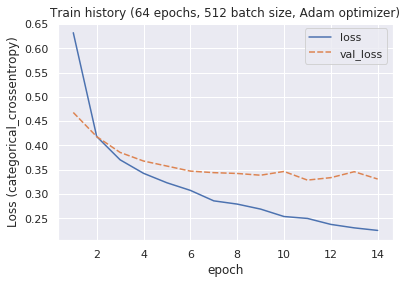

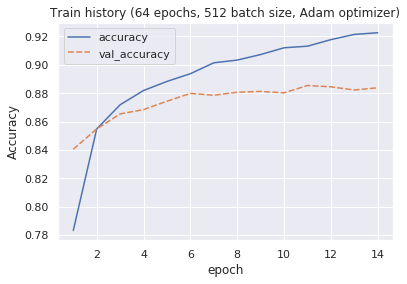

In [0]:
history, best_model = train(model, X_train, Y_train, X_val, Y_val, 
                            n_epochs=64, batch_size=512)

In [0]:
strftime('%X')

'22:34:09'

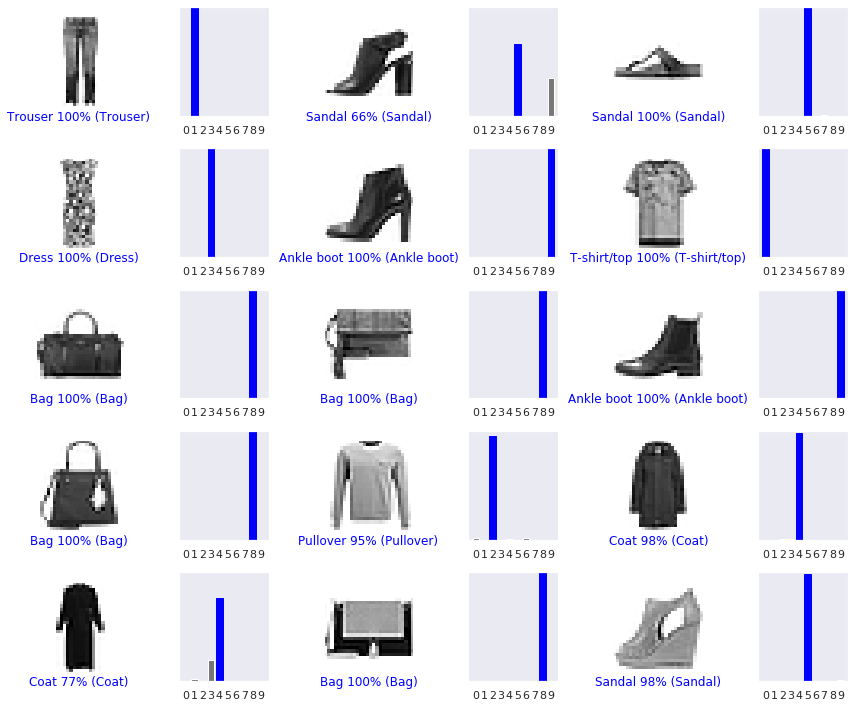

In [0]:
Y_val_pred = best_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_pred)

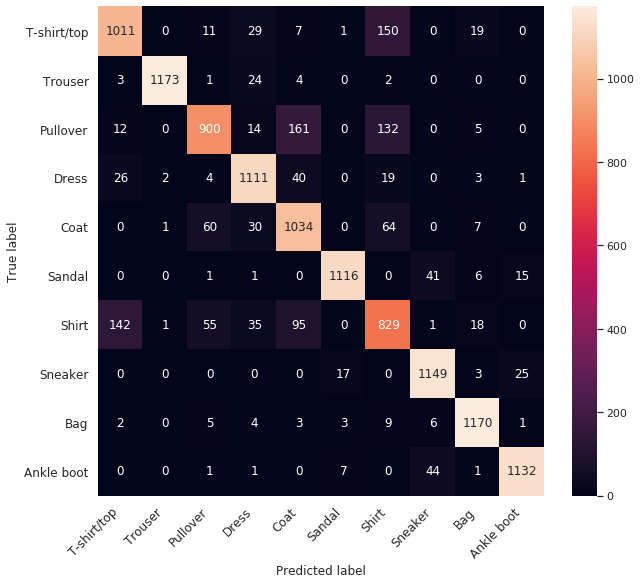

In [0]:
print_cm(ys_val, np.argmax(Y_val_pred, axis=1), CLASS_NAME)

## 1.2. CNN

In [0]:
# obs.: padding='valid' by default (i.e. no padding)
conv_model = keras.Sequential([
    Reshape((28, 28, 1), input_shape=(784,)),
    Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)), # 28x28 -> 14x14 feature map
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)), # 14x14 -> 7x7 feature map
    Flatten(), # 7*7*64 = 3136
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "CNN_baseline")

In [0]:
conv_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [0]:
conv_model.summary()

Model: "CNN_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [0]:
conv_model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

In [0]:
strftime('%X')

'22:34:14'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 6s 121us/sample - loss: 0.7163 - accuracy: 0.7660 - val_loss: 0.4722 - val_accuracy: 0.8404
Epoch 2/64
48000/48000 [==============================] - 2s 50us/sample - loss: 0.4252 - accuracy: 0.8571 - val_loss: 0.3957 - val_accuracy: 0.8682
Epoch 3/64
48000/48000 [==============================] - 2s 49us/sample - loss: 0.3768 - accuracy: 0.8749 - val_loss: 0.3677 - val_accuracy: 0.8809
Epoch 4/64
48000/48000 [==============================] - 2s 49us/sample - loss: 0.3442 - accuracy: 0.8879 - val_loss: 0.3512 - val_accuracy: 0.8838
Epoch 5/64
48000/48000 [==============================] - 2s 49us/sample - loss: 0.3272 - accuracy: 0.8942 - val_loss: 0.3308 - val_accuracy: 0.8923
Epoch 6/64
48000/48000 [==============================] - 2s 49us/sample - loss: 0.3110 - accuracy: 0.8994 - val_loss: 0.3185 - val_accuracy: 0.8965
Epoch 7/64
48000/48000 [==========

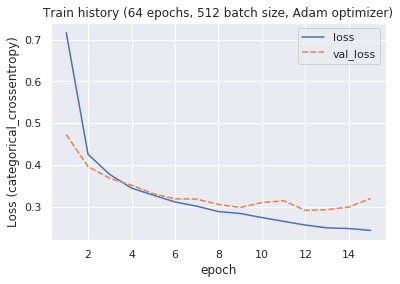

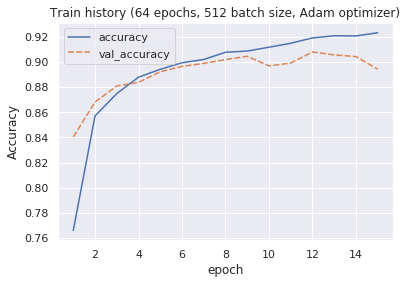

In [0]:
conv_history, best_conv_model = train(conv_model, X_train, Y_train, X_val, Y_val, 
                                      n_epochs=64, batch_size=512)

In [0]:
strftime('%X')

'22:34:54'

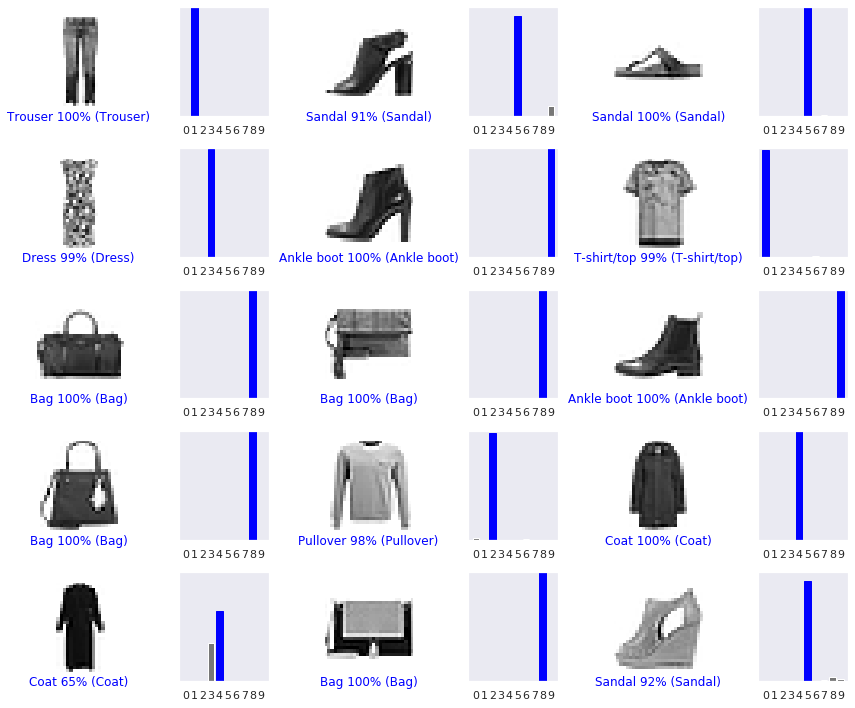

In [0]:
Y_val_conv_pred = best_conv_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_conv_pred)

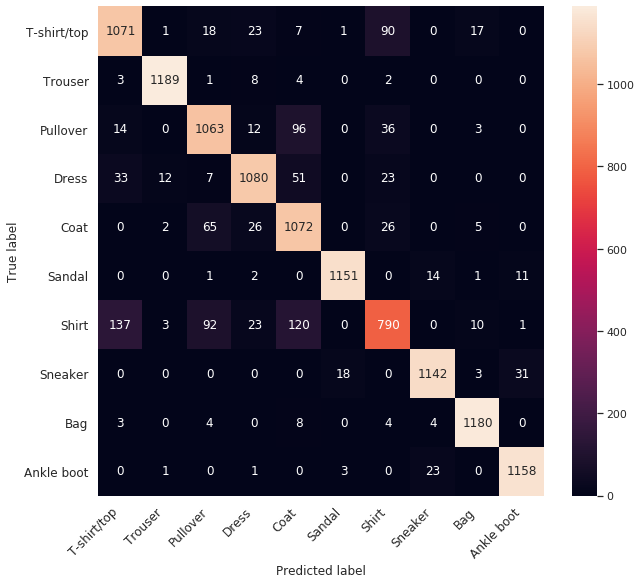

In [0]:
print_cm(ys_val, np.argmax(Y_val_conv_pred, axis=1), CLASS_NAME)

## 1.3. CNN with batch normalization

In [0]:
from tensorflow.keras.layers import Dropout, BatchNormalization, ReLU

In [0]:
# obs.: padding='valid' by default (i.e. no padding)
conv_v2_model = keras.Sequential([
    Reshape((28, 28, 1), input_shape=(784,)),
    Conv2D(32, (5, 5), padding='same', input_shape=(28, 28, 1)),
    ReLU(),
    BatchNormalization(),
    MaxPooling2D((2, 2)), # 28x28 -> 14x14 feature map
    Conv2D(64, (3, 3), padding='same'),
    ReLU(),
    BatchNormalization(),
    MaxPooling2D((2, 2)), # 14x14 -> 7x7 feature map
    Flatten(), # 7*7*64 = 3136
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "CNN_v2_baseline")

In [0]:
conv_v2_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

In [0]:
conv_v2_model.summary()

Model: "CNN_v2_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
re_lu (ReLU)                 (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 64)    

In [0]:
conv_v2_model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

In [0]:
strftime('%X')

'22:35:00'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 4s 82us/sample - loss: 0.5433 - accuracy: 0.8171 - val_loss: 1.3636 - val_accuracy: 0.5865
Epoch 2/64
48000/48000 [==============================] - 3s 63us/sample - loss: 0.3361 - accuracy: 0.8874 - val_loss: 1.1075 - val_accuracy: 0.6405
Epoch 3/64
48000/48000 [==============================] - 3s 63us/sample - loss: 0.2902 - accuracy: 0.9041 - val_loss: 0.7266 - val_accuracy: 0.7792
Epoch 4/64
48000/48000 [==============================] - 3s 63us/sample - loss: 0.2614 - accuracy: 0.9133 - val_loss: 0.4638 - val_accuracy: 0.8514
Epoch 5/64
48000/48000 [==============================] - 3s 64us/sample - loss: 0.2393 - accuracy: 0.9205 - val_loss: 0.3470 - val_accuracy: 0.8878
Epoch 6/64
48000/48000 [==============================] - 3s 64us/sample - loss: 0.2191 - accuracy: 0.9281 - val_loss: 0.2885 - val_accuracy: 0.9030
Epoch 7/64
48000/48000 [===========

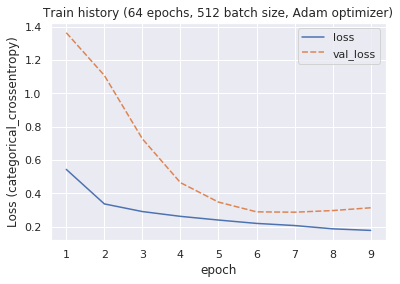

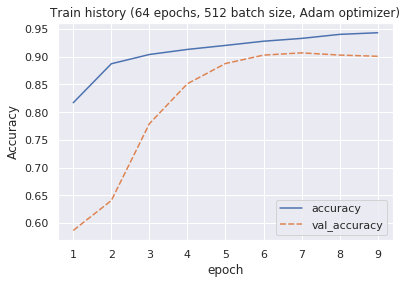

In [0]:
conv_v2_history, best_conv_v2_model = train(conv_v2_model, X_train, Y_train, X_val, Y_val, 
                                            n_epochs=64, batch_size=512)

In [0]:
strftime('%X')

'22:35:30'

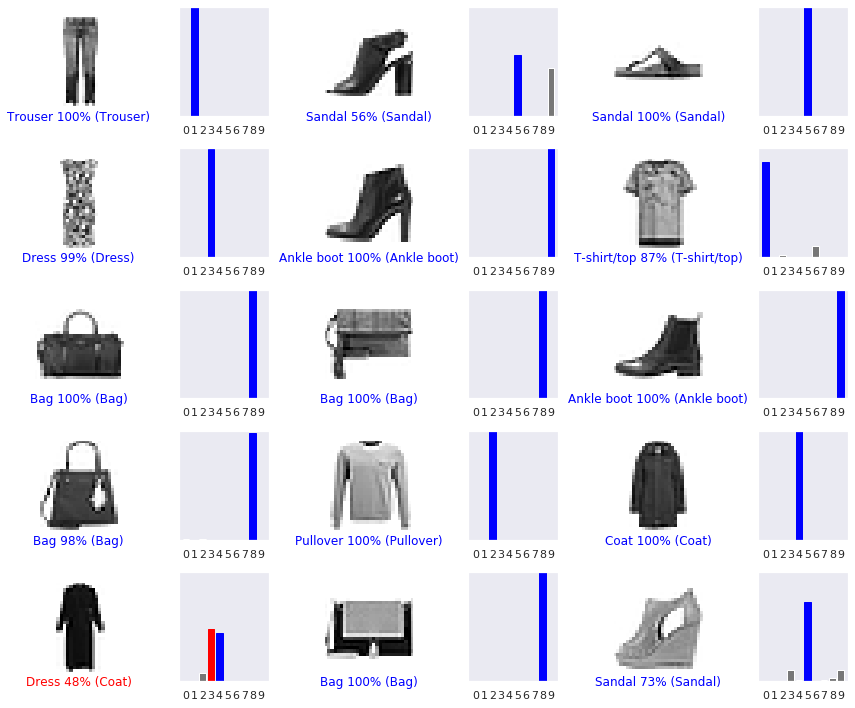

In [0]:
Y_val_conv_v2_pred = best_conv_v2_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_conv_v2_pred)

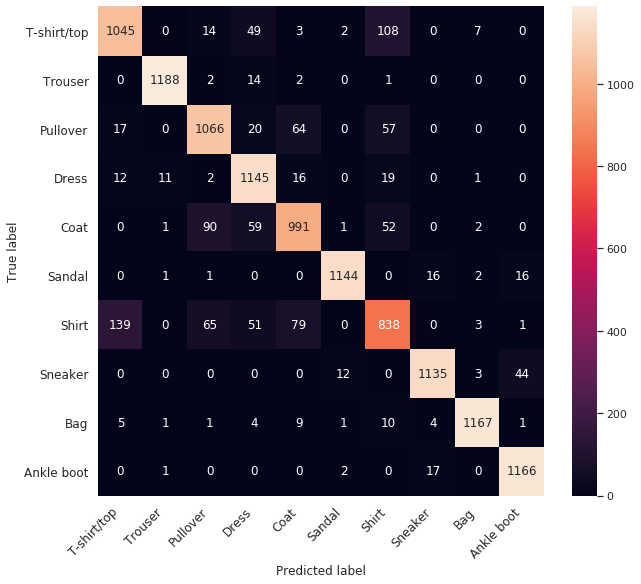

In [0]:
print_cm(ys_val, np.argmax(Y_val_conv_v2_pred, axis=1), CLASS_NAME)

## 2. Using PCA
Re-do the ﬁrst experiment considering the PCA dimensionality reduction. Consider three diﬀerent energies (variance) for reducing the image dimensionality. What are the conclusions when using PCA in this problem? Does the accuracy improve?

In [0]:
from sklearn.decomposition import PCA

In [0]:
def print_info(array, name):
    print(f"{name+':':<9} {array.dtype.name:<7} {str(array.shape):<12} "
          f"| min: {array.min():>5.2f} | max: {array.max():>5.2f} "
          f"| mean: {array.mean():>5.3f} | std: {array.std():>5.3f}")

In [39]:
print_info(X_train, "X_train")
print_info(xs_train, "xs_train")
print_info(Y_train, "Y_train")
print_info(ys_train, "ys_train")

X_train:  float32 (48000, 784) | min: -0.81 | max:  2.03 | mean: -0.000 | std: 1.000
xs_train: float32 (48000, 784) | min:  0.00 | max:  1.00 | mean: 0.286 | std: 0.353
Y_train:  float64 (48000, 10)  | min:  0.00 | max:  1.00 | mean: 0.100 | std: 0.300
ys_train: uint8   (48000,)     | min:  0.00 | max:  9.00 | mean: 4.507 | std: 2.871


_As we'll be reducing the amount of features (dimensions) of our input data after applying PCA, it makes more sense to treat it as a vector, instead of as an image.
Thus, we'll use our MLP baseline model instead of our CNN, even though the latter showed better results._

In [0]:
def build_pca_model(min_explained_variance, model_name):
    pca = PCA(min_explained_variance)
    pca.fit(X_train) # fit on train data (and then use it to transform both train and validation)
    print(pca)
    print()
    
    explained_variance = pca.explained_variance_ratio_.sum()
    print(f"{pca.n_components_} principal components → {explained_variance} explained variance")
    print(f"{pca.n_components_} / {X_train.shape[1]} = {(100 * pca.n_components_ / X_train.shape[1]):.2f}% of components used")
    
    model_pca = keras.Sequential([
        Input(shape=(pca.n_components_, )), # number of components used to keep min_explained_variance
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
    ], model_name)
    
    model_pca.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    return model_pca, pca

In [0]:
def train_pca_model(model_pca, pca):
    history_pca, best_model_pca = train(model_pca, 
                                        pca.transform(X_train), Y_train, 
                                        pca.transform(X_val), Y_val, 
                                        n_epochs=64, batch_size=512)

    # using ys_val below, instead of np.argmax(Y_val, axis=1), simply for convinence

    Y_val_pca_pred = best_model_pca.predict(pca.transform(X_val))
    plot_image_with_prediction(X_val, ys_val, Y_val_pca_pred)

    print_cm(ys_val, np.argmax(Y_val_pca_pred, axis=1), CLASS_NAME)
    
    return Y_val_pca_pred

## 2.1. 99% explained variance

In [0]:
model_99var, pca_99var = build_pca_model(min_explained_variance=0.99, model_name="MLP_99var")

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

458 principal components → 0.990027666091919 explained variance
458 / 784 = 58.42% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 22us/sample - loss: 0.8053 - accuracy: 0.7430 - val_loss: 0.4498 - val_accuracy: 0.8495
Epoch 2/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3861 - accuracy: 0.8704 - val_loss: 0.3945 - val_accuracy: 0.8642
Epoch 3/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3295 - accuracy: 0.8899 - val_loss: 0.3725 - val_accuracy: 0.8754
Epoch 4/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.2946 - accuracy: 0.9016 - val_loss: 0.3625 - val_accuracy: 0.8768
Epoch 5/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.2648 - accuracy: 0.9134 - val_loss: 0.3566 - val_accuracy: 0.8798
Epoch 6/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.2418 - accuracy: 0.9234 - val_loss: 0.3555 - val_accuracy: 0.8811
Epoch 7/64
48000/48000 [===========

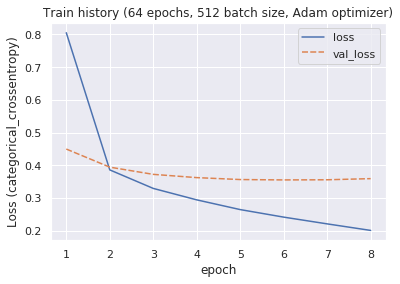

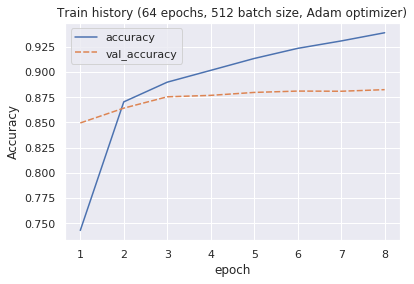

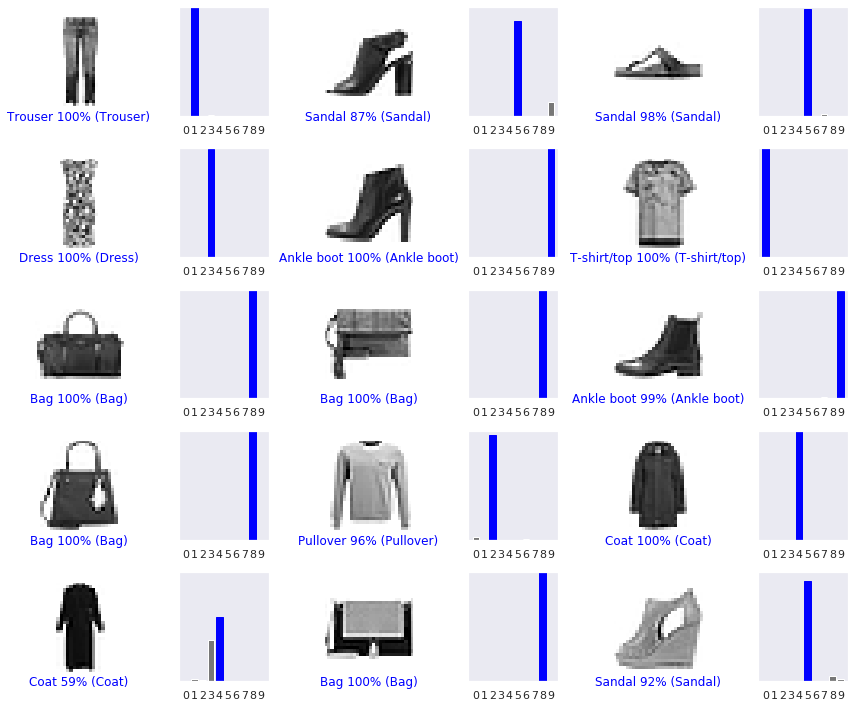

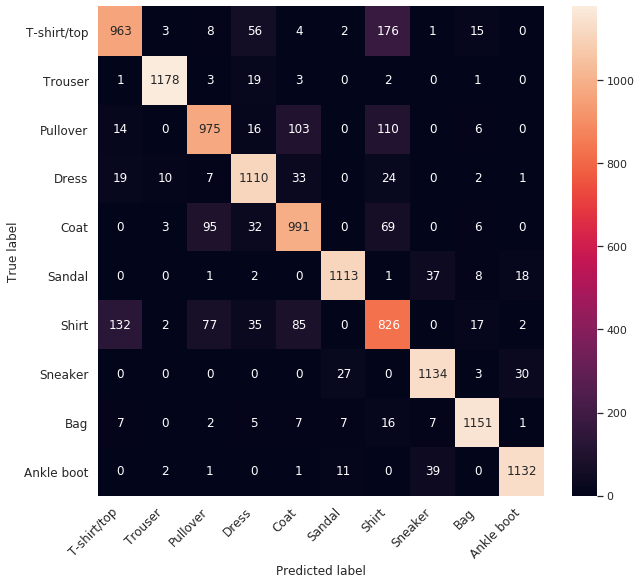

In [0]:
Y_val_99var_pred = train_pca_model(model_99var, pca_99var)

## 2.2. 95% explained variance

In [0]:
model_95var, pca_95var = build_pca_model(min_explained_variance=0.95, model_name="MLP_95var")

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

187 principal components → 0.9500905871391296 explained variance
187 / 784 = 23.85% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 22us/sample - loss: 0.7989 - accuracy: 0.7402 - val_loss: 0.4577 - val_accuracy: 0.8456
Epoch 2/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4069 - accuracy: 0.8640 - val_loss: 0.3992 - val_accuracy: 0.8638
Epoch 3/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3559 - accuracy: 0.8809 - val_loss: 0.3751 - val_accuracy: 0.8728
Epoch 4/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3257 - accuracy: 0.8910 - val_loss: 0.3588 - val_accuracy: 0.8787
Epoch 5/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.3016 - accuracy: 0.8993 - val_loss: 0.3468 - val_accuracy: 0.8823
Epoch 6/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.2836 - accuracy: 0.9052 - val_loss: 0.3457 - val_accuracy: 0.8827
Epoch 7/64
48000/48000 [===========

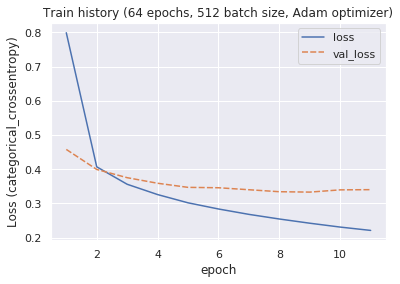

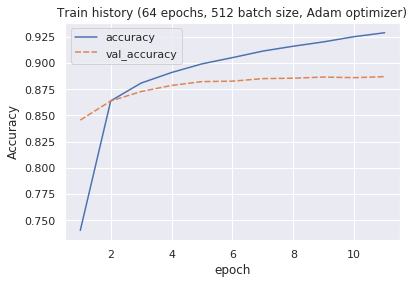

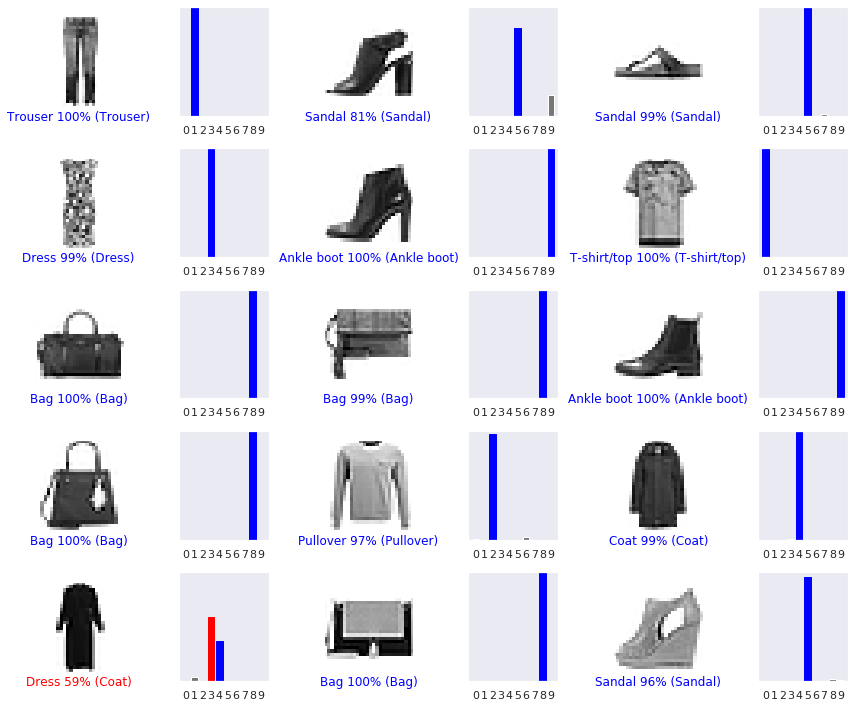

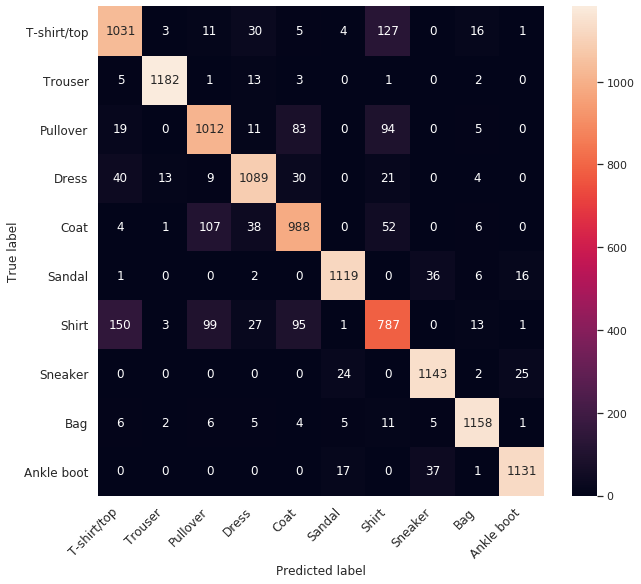

In [0]:
Y_val_95var_pred = train_pca_model(model_95var, pca_95var)

## 2.3. 90% explained variance

In [0]:
model_90var, pca_90var = build_pca_model(min_explained_variance=0.90, model_name="MLP_90var")

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

84 principal components → 0.9006666541099548 explained variance
84 / 784 = 10.71% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 22us/sample - loss: 0.8856 - accuracy: 0.7121 - val_loss: 0.4938 - val_accuracy: 0.8333
Epoch 2/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4423 - accuracy: 0.8487 - val_loss: 0.4241 - val_accuracy: 0.8524
Epoch 3/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.3908 - accuracy: 0.8659 - val_loss: 0.3932 - val_accuracy: 0.8645
Epoch 4/64
48000/48000 [==============================] - 1s 10us/sample - loss: 0.3626 - accuracy: 0.8765 - val_loss: 0.3774 - val_accuracy: 0.8708
Epoch 5/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.3424 - accuracy: 0.8832 - val_loss: 0.3672 - val_accuracy: 0.8744
Epoch 6/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.3264 - accuracy: 0.8887 - val_loss: 0.3604 - val_accuracy: 0.8763
Epoch 7/64
48000/48000 [===========

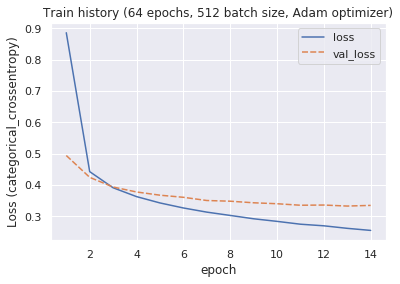

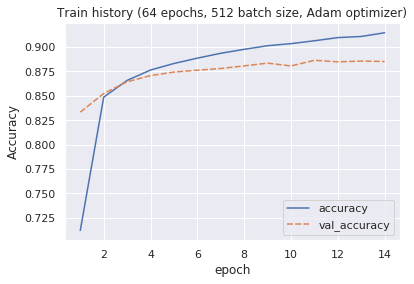

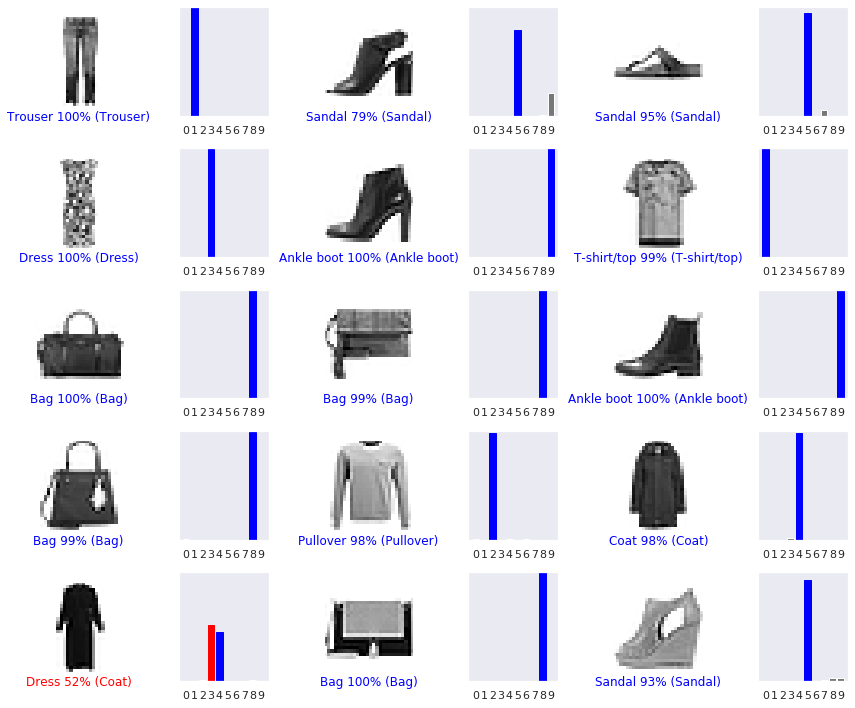

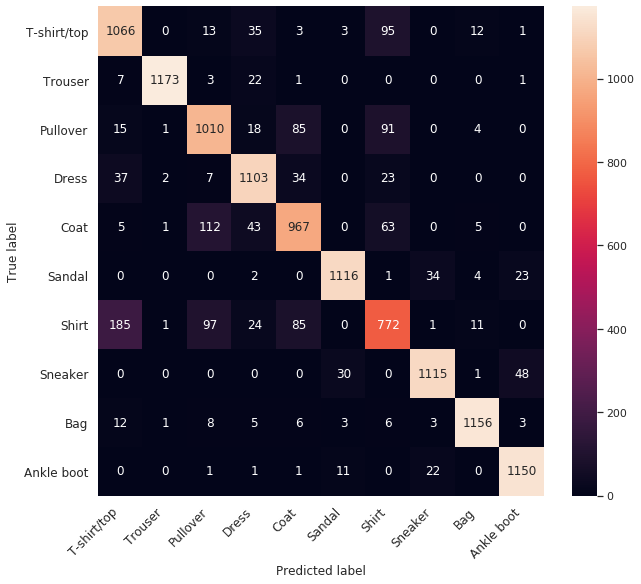

In [0]:
Y_val_90var_pred = train_pca_model(model_90var, pca_90var)

## 2.4. F1-scores

In [0]:
from sklearn.metrics import precision_recall_fscore_support

In [0]:
def print_f1_scores(ys, ys_pred, class_name_dict=CLASS_NAME):
    # ref.: https://github.com/erikperillo/ml-2sem2019/
    def harmonic_mean_of_positive_values(values, eps=1e-18):
        return len(values) / sum(1 / max(v, eps) for v in values)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(ys, ys_pred)
    print("                       Precision    Recall    F1-score")
    for i, (p, r, f1) in enumerate(zip(precision, recall, f1_score)):
        print(f"Class {i} {f'({class_name_dict[i]}):':<16} {p:.4f}  |  {r:.4f}  |  {f1:.4f}")
    print()
    print(f"Combined F1 score:  {len(f1_score) / sum(1 / max(v, 1e-18) for v in f1_score):.4f}")
    print(f"Combined Precision: {len(precision) / sum(1 / max(v, 1e-18) for v in precision):.4f}")
    print(f"Combined Recall:    {len(recall) / sum(1 / max(v, 1e-18) for v in recall):.4f}")

In [0]:
# MLP baseline
print_f1_scores(ys_val, np.argmax(Y_val_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8453  |  0.8233  |  0.8342
Class 1 (Trouser):       0.9966  |  0.9718  |  0.9841
Class 2 (Pullover):      0.8671  |  0.7353  |  0.7958
Class 3 (Dress):         0.8895  |  0.9212  |  0.9051
Class 4 (Coat):          0.7693  |  0.8645  |  0.8142
Class 5 (Sandal):        0.9755  |  0.9458  |  0.9604
Class 6 (Shirt):         0.6880  |  0.7049  |  0.6963
Class 7 (Sneaker):       0.9259  |  0.9623  |  0.9437
Class 8 (Bag):           0.9497  |  0.9726  |  0.9610
Class 9 (Ankle boot):    0.9642  |  0.9545  |  0.9593

Combined F1 score:  0.8753
Combined Precision: 0.8762
Combined Recall:    0.8744


In [0]:
# CNN baseline
print_f1_scores(ys_val, np.argmax(Y_val_conv_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8493  |  0.8721  |  0.8606
Class 1 (Trouser):       0.9843  |  0.9851  |  0.9847
Class 2 (Pullover):      0.8497  |  0.8685  |  0.8590
Class 3 (Dress):         0.9191  |  0.8955  |  0.9072
Class 4 (Coat):          0.7894  |  0.8963  |  0.8395
Class 5 (Sandal):        0.9812  |  0.9754  |  0.9783
Class 6 (Shirt):         0.8136  |  0.6718  |  0.7359
Class 7 (Sneaker):       0.9653  |  0.9564  |  0.9609
Class 8 (Bag):           0.9680  |  0.9809  |  0.9744
Class 9 (Ankle boot):    0.9642  |  0.9764  |  0.9703

Combined F1 score:  0.8998
Combined Precision: 0.9026
Combined Recall:    0.8970


In [0]:
# 99% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_99var_pred, axis=1), CLASS_NAME) # FIXME why is this worse than 95% ?

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8477  |  0.7842  |  0.8147
Class 1 (Trouser):       0.9833  |  0.9760  |  0.9796
Class 2 (Pullover):      0.8340  |  0.7966  |  0.8149
Class 3 (Dress):         0.8706  |  0.9204  |  0.8948
Class 4 (Coat):          0.8077  |  0.8286  |  0.8180
Class 5 (Sandal):        0.9595  |  0.9432  |  0.9513
Class 6 (Shirt):         0.6748  |  0.7024  |  0.6883
Class 7 (Sneaker):       0.9310  |  0.9497  |  0.9403
Class 8 (Bag):           0.9520  |  0.9568  |  0.9544
Class 9 (Ankle boot):    0.9561  |  0.9545  |  0.9553

Combined F1 score:  0.8713
Combined Precision: 0.8713
Combined Recall:    0.8712


In [0]:
# 95% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_95var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8209  |  0.8396  |  0.8301
Class 1 (Trouser):       0.9817  |  0.9793  |  0.9805
Class 2 (Pullover):      0.8129  |  0.8268  |  0.8198
Class 3 (Dress):         0.8963  |  0.9030  |  0.8996
Class 4 (Coat):          0.8179  |  0.8261  |  0.8220
Class 5 (Sandal):        0.9564  |  0.9483  |  0.9523
Class 6 (Shirt):         0.7200  |  0.6692  |  0.6937
Class 7 (Sneaker):       0.9361  |  0.9573  |  0.9466
Class 8 (Bag):           0.9547  |  0.9626  |  0.9586
Class 9 (Ankle boot):    0.9626  |  0.9536  |  0.9581

Combined F1 score:  0.8766
Combined Precision: 0.8776
Combined Recall:    0.8756


In [0]:
# 90% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_90var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8033  |  0.8681  |  0.8344
Class 1 (Trouser):       0.9949  |  0.9718  |  0.9832
Class 2 (Pullover):      0.8074  |  0.8252  |  0.8162
Class 3 (Dress):         0.8803  |  0.9146  |  0.8971
Class 4 (Coat):          0.8181  |  0.8085  |  0.8133
Class 5 (Sandal):        0.9596  |  0.9458  |  0.9526
Class 6 (Shirt):         0.7345  |  0.6565  |  0.6933
Class 7 (Sneaker):       0.9489  |  0.9338  |  0.9413
Class 8 (Bag):           0.9690  |  0.9609  |  0.9649
Class 9 (Ankle boot):    0.9380  |  0.9696  |  0.9536

Combined F1 score:  0.8753
Combined Precision: 0.8770
Combined Recall:    0.8736


## 2.4. <90% explained variance

**80% explained variance**

In [0]:
model_80var, pca_80var = build_pca_model(min_explained_variance=0.80, model_name="MLP_80var")

PCA(copy=True, iterated_power='auto', n_components=0.8, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

24 principal components → 0.8010118007659912 explained variance
24 / 784 = 3.06% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 21us/sample - loss: 0.8649 - accuracy: 0.7254 - val_loss: 0.5409 - val_accuracy: 0.8178
Epoch 2/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4983 - accuracy: 0.8286 - val_loss: 0.4832 - val_accuracy: 0.8362
Epoch 3/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4551 - accuracy: 0.8439 - val_loss: 0.4549 - val_accuracy: 0.8436
Epoch 4/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4304 - accuracy: 0.8525 - val_loss: 0.4352 - val_accuracy: 0.8505
Epoch 5/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4148 - accuracy: 0.8568 - val_loss: 0.4205 - val_accuracy: 0.8552
Epoch 6/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4007 - accuracy: 0.8625 - val_loss: 0.4109 - val_accuracy: 0.8595
Epoch 7/64
48000/48000 [===========

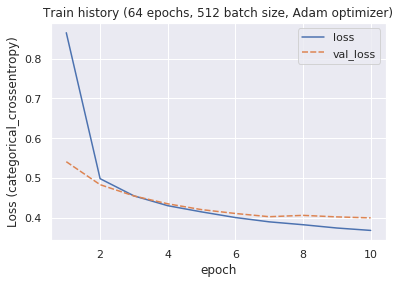

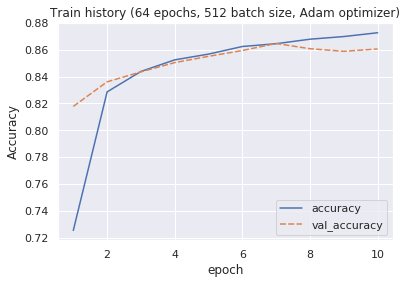

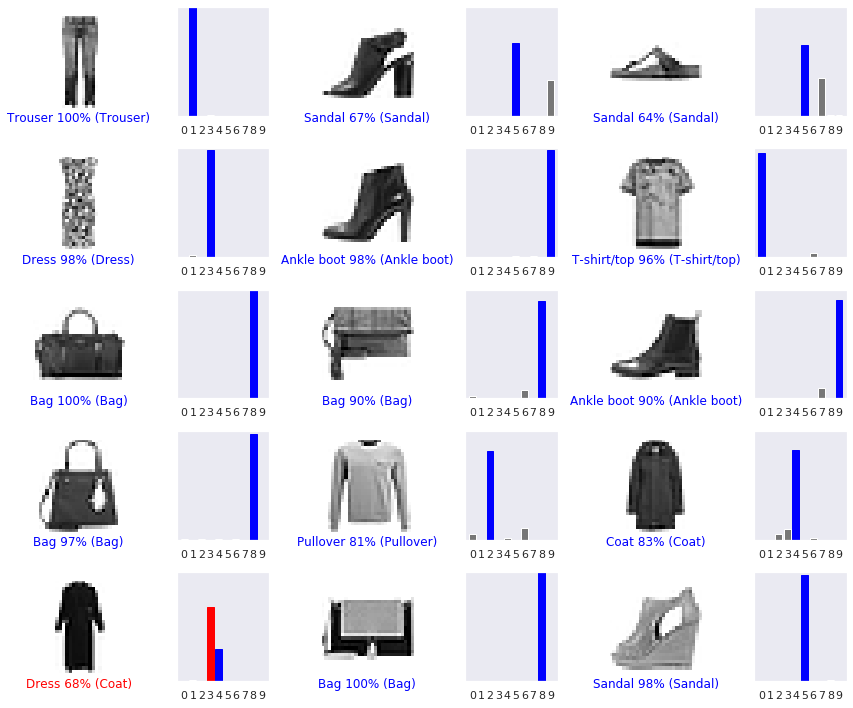

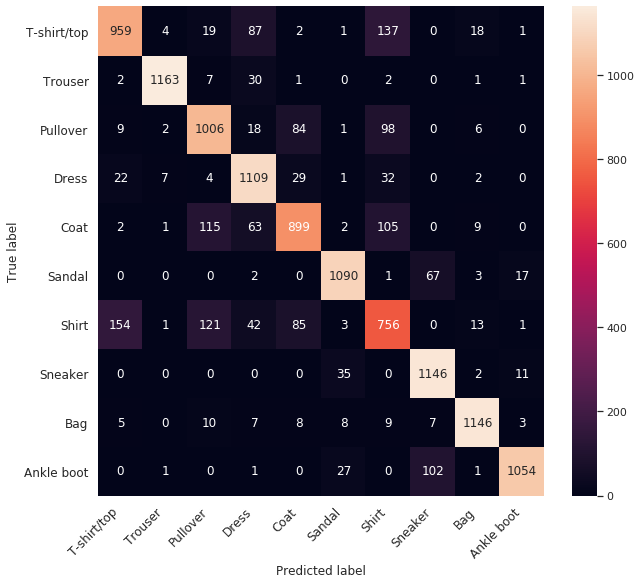

In [0]:
Y_val_80var_pred = train_pca_model(model_80var, pca_80var)

In [0]:
# 80% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_80var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8317  |  0.7809  |  0.8055
Class 1 (Trouser):       0.9864  |  0.9635  |  0.9749
Class 2 (Pullover):      0.7847  |  0.8219  |  0.8029
Class 3 (Dress):         0.8160  |  0.9196  |  0.8647
Class 4 (Coat):          0.8114  |  0.7517  |  0.7804
Class 5 (Sandal):        0.9332  |  0.9237  |  0.9284
Class 6 (Shirt):         0.6632  |  0.6429  |  0.6528
Class 7 (Sneaker):       0.8669  |  0.9598  |  0.9110
Class 8 (Bag):           0.9542  |  0.9526  |  0.9534
Class 9 (Ankle boot):    0.9688  |  0.8887  |  0.9270

Combined F1 score:  0.8486
Combined Precision: 0.8502
Combined Recall:    0.8469


**60% explained variance**

In [0]:
model_60var, pca_60var = build_pca_model(min_explained_variance=0.60, model_name="MLP_60var")

PCA(copy=True, iterated_power='auto', n_components=0.6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

5 principal components → 0.6160919666290283 explained variance
5 / 784 = 0.64% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 27us/sample - loss: 1.1466 - accuracy: 0.6164 - val_loss: 0.7981 - val_accuracy: 0.7092
Epoch 2/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.7674 - accuracy: 0.7139 - val_loss: 0.7449 - val_accuracy: 0.7220
Epoch 3/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.7309 - accuracy: 0.7241 - val_loss: 0.7188 - val_accuracy: 0.7295
Epoch 4/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.7117 - accuracy: 0.7296 - val_loss: 0.7080 - val_accuracy: 0.7334
Epoch 5/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.6994 - accuracy: 0.7332 - val_loss: 0.6960 - val_accuracy: 0.7372
Epoch 6/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.6900 - accuracy: 0.7385 - val_loss: 0.6912 - val_accuracy: 0.7323
Epoch 7/64
48000/48000 [===========

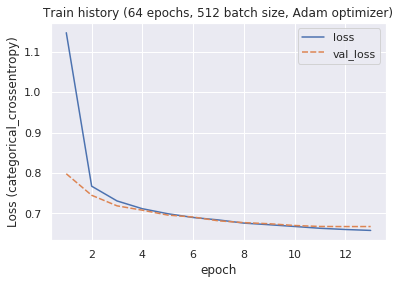

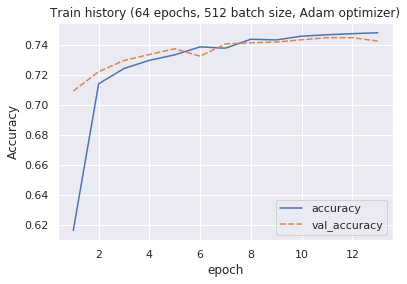

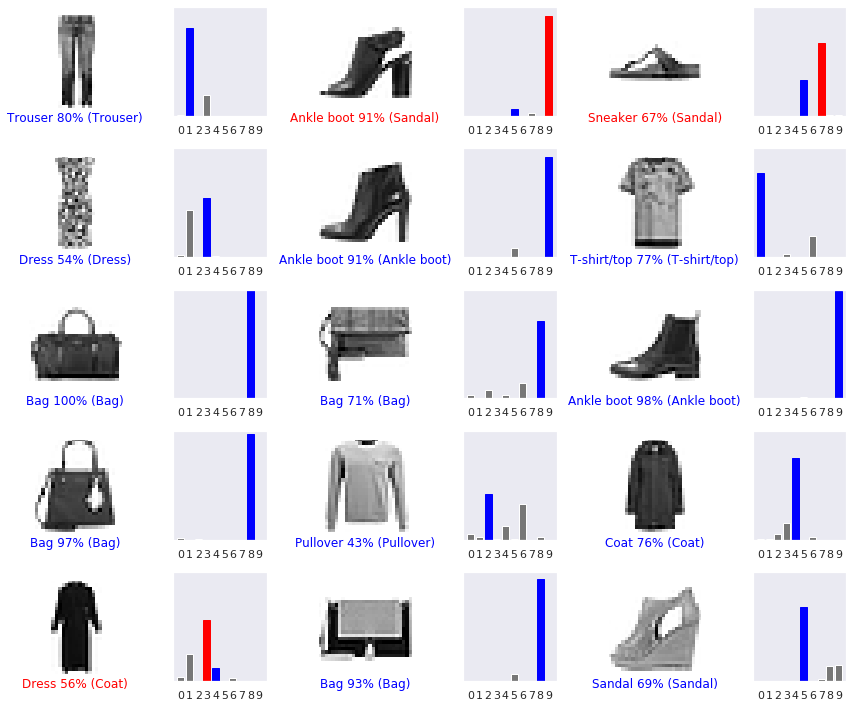

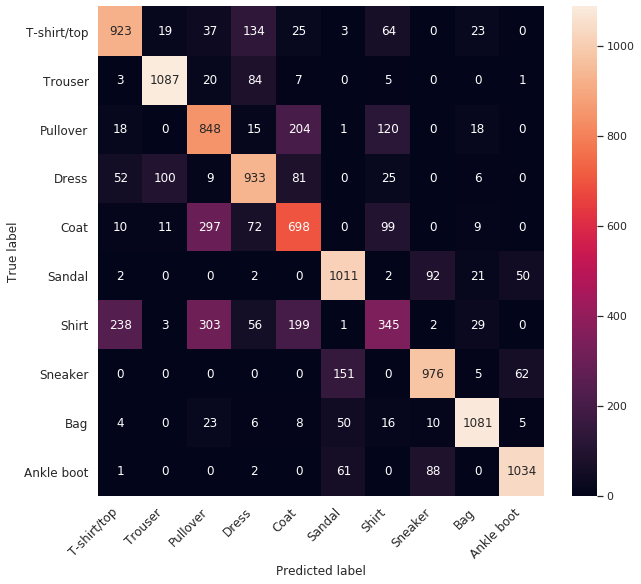

In [0]:
Y_val_60var_pred = train_pca_model(model_60var, pca_60var)

In [0]:
# 60% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_60var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7378  |  0.7516  |  0.7447
Class 1 (Trouser):       0.8910  |  0.9006  |  0.8958
Class 2 (Pullover):      0.5517  |  0.6928  |  0.6143
Class 3 (Dress):         0.7155  |  0.7736  |  0.7434
Class 4 (Coat):          0.5712  |  0.5836  |  0.5773
Class 5 (Sandal):        0.7911  |  0.8568  |  0.8226
Class 6 (Shirt):         0.5104  |  0.2934  |  0.3726
Class 7 (Sneaker):       0.8356  |  0.8174  |  0.8264
Class 8 (Bag):           0.9069  |  0.8986  |  0.9027
Class 9 (Ankle boot):    0.8976  |  0.8718  |  0.8845

Combined F1 score:  0.6891
Combined Precision: 0.7104
Combined Recall:    0.6689


## 2.5. Plot the first 3 principal components

In [0]:
pca_3pc = PCA(n_components=3)

In [0]:
pca_3pc_result = pca_3pc.fit_transform(X_train)

In [44]:
print(f"Explained variance per principal component:")
for i, (var, cumsum) in enumerate(zip(pca_3pc.explained_variance_ratio_, np.cumsum(pca_3pc.explained_variance_ratio_))):
    print(f"PC {i+1}: {var:.4f} (cumulative sum: {cumsum:.2f})")

Explained variance per principal component:
PC 1: 0.2902 (cumulative sum: 0.29)
PC 2: 0.1773 (cumulative sum: 0.47)
PC 3: 0.0604 (cumulative sum: 0.53)


In [48]:
if COLAB:
  plt.figure(figsize=(16, 10))
  sns.scatterplot(
      x=pca_3pc_result[..., 0], # PC 1
      y=pca_3pc_result[..., 1], # PC 2
      hue="label",
      palette=sns.color_palette("hls", 10),
      data=train_dataset,
      legend="full",
      alpha=0.3
  )

AttributeError: ignored

<Figure size 1152x720 with 0 Axes>

In [0]:
from mpl_toolkits.mplot3d import Axes3D

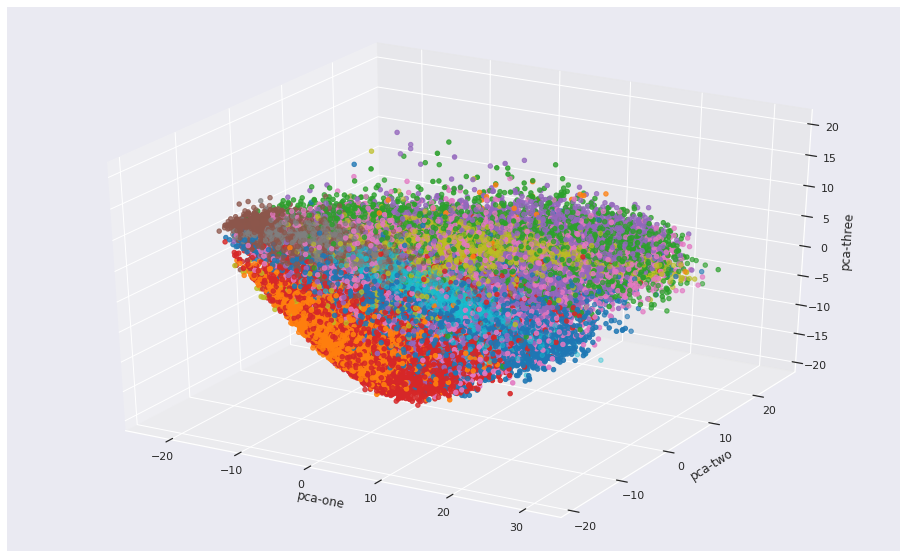

In [50]:
# run '%matplotlib notebook' for an interactive (but laggy) visualization
ax = plt.figure(figsize=(16, 10)).gca(projection='3d')
ax.scatter(
    xs=pca_3pc_result[..., 0], # PC 1
    ys=pca_3pc_result[..., 1], # PC 2
    zs=pca_3pc_result[..., 2], # PC 3
    c=ys_train, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## 3. Using Autoencoders
Re-do the ﬁrst experiment considering Autoencoders for reducing the image dimensionality. Consider two diﬀerent latent vector size for reducing the image dimensionality. What are the conclusions when using Autoencoders in this problem? Does accuracy improve?

Autoencoders are a branch of neural network which attempt to compress the information of the input variables into a reduced dimensional space and then recreate the input data set. Typically the autoencoder is trained over a number of iterations using gradient descent, minimizing the mean squared error. The key component is the “bottleneck” hidden layer. This is where the information from the input has been compressed. By extracting this layer from the model, each node can now be treated as a variable in the same way each chosen principal component is used as a variable in following models.


In [0]:
from tensorflow.keras import Model
# ref.: https://blog.keras.io/building-autoencoders-in-keras.html
#       https://www.tensorflow.org/tutorials/generative/cvae

In [0]:
def build_autoencoder(latent_dim):
    __input   = Input(shape=(784,)) # 28 * 28 = 784 pixels
    __encoded = Dense(latent_dim, activation='relu', activity_regularizer=l1(1e-4))(__input)
    __decoded = Dense(784, activation='sigmoid')(__encoded)

    autoencoder = Model(__input, __decoded)
    print("Autoencoder summary:")
    print(autoencoder.summary())

    encoder = Model(__input, __encoded)
    print("Encoder summary:")
    print(encoder.summary())

    # create a placeholder for an encoded (24-dimensional) input
    encoded_input = Input(shape=(latent_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]

    decoder = Model(encoded_input, decoder_layer(encoded_input))
    print("Decoder summary:")
    print(decoder.summary())

    autoencoder.compile(optimizer='adam', loss='mse')

    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.003, patience=3)]

    autoencoder.fit(X_train, X_train,
                    validation_data=(X_val, X_val),
                    epochs=64,
                    batch_size=512,
                    shuffle=True,
                    callbacks=callbacks)
    return autoencoder, encoder, decoder

In [0]:
def show_autoencoder_sample(encoder, decoder):
    # encode and decode some digits
    encoded_imgs = encoder.predict(X_val)
    decoded_imgs = decoder.predict(encoded_imgs)

    n = 10 # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_val[i].reshape(28, 28), cmap='binary')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='binary')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    ###

In [0]:
def train_ae_model(encoder, latent_dim, model_name):
    model = keras.Sequential([
        Input(shape=(latent_dim, )), # number of components used to keep min_explained_variance
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
    ], model_name)

    model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

    history_ae, best_model_ae = train(model, 
                                      encoder.predict(X_train), Y_train, 
                                      encoder.predict(X_val), Y_val, 
                                      n_epochs=64, batch_size=512)

    # using ys_val below, instead of np.argmax(Y_val, axis=1), simply for convinence

    Y_val_ae_pred = best_model_ae.predict(encoder.predict(X_val))
    plot_image_with_prediction(X_val, ys_val, Y_val_ae_pred)

    print_cm(ys_val, np.argmax(Y_val_ae_pred, axis=1), CLASS_NAME)
    
    return Y_val_ae_pred, best_model_ae

## 3.1. Latent vector size of 84

In [0]:
latent_dim = 84

In [110]:
autoencoder_84, encoder_84, decoder_84 = build_autoencoder(latent_dim)

Autoencoder summary:
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 84)                65940     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               66640     
Total params: 132,580
Trainable params: 132,580
Non-trainable params: 0
_________________________________________________________________
None
Encoder summary:
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 84)                6594

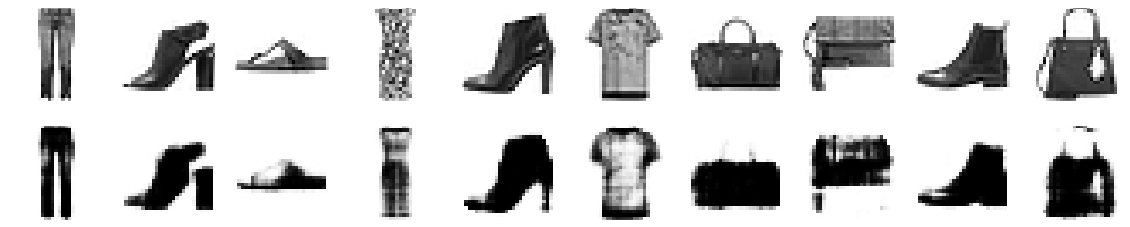

In [111]:
show_autoencoder_sample(encoder_84, decoder_84)

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 23us/sample - loss: 0.9035 - accuracy: 0.7081 - val_loss: 0.5185 - val_accuracy: 0.8205
Epoch 2/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4648 - accuracy: 0.8377 - val_loss: 0.4458 - val_accuracy: 0.8453
Epoch 3/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4137 - accuracy: 0.8538 - val_loss: 0.4332 - val_accuracy: 0.8448
Epoch 4/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.3884 - accuracy: 0.8647 - val_loss: 0.4040 - val_accuracy: 0.8574
Epoch 5/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.3678 - accuracy: 0.8702 - val_loss: 0.3909 - val_accuracy: 0.8625
Epoch 6/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.3548 - accuracy: 0.8753 - val_loss: 0.3901 - val_accuracy: 0.8623
Epoch 7/64
48000/48000 [===========

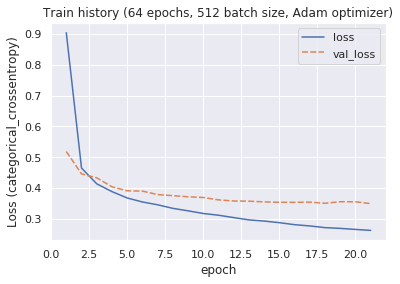

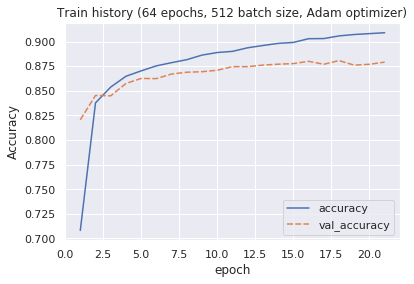

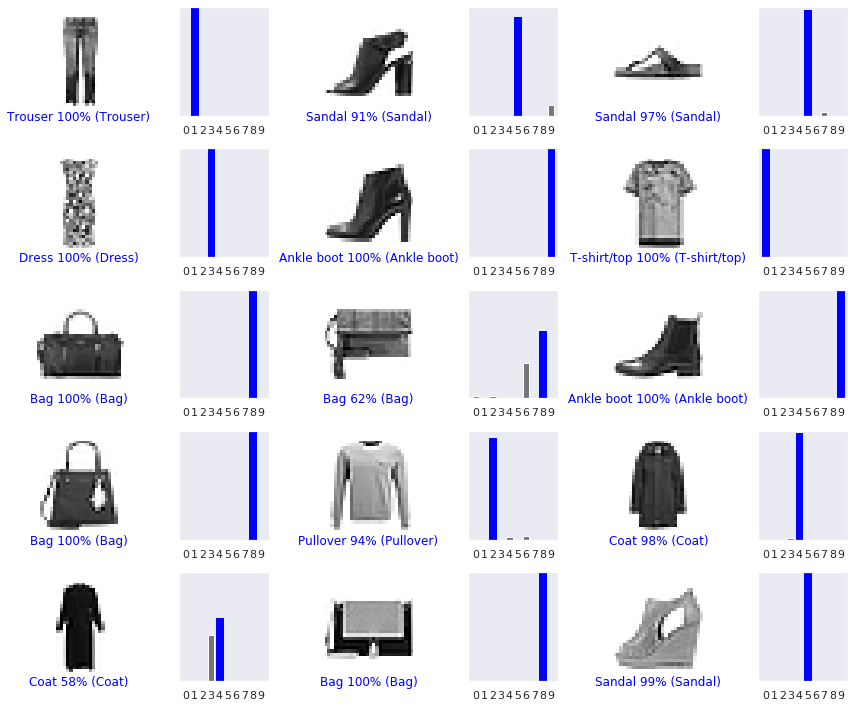

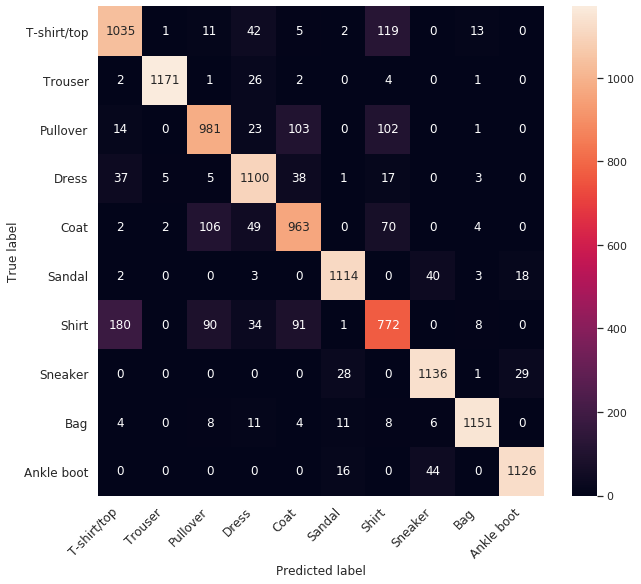

In [116]:
Y_val_ae_84_pred, model_ae_84 = train_ae_model(encoder_84, latent_dim, model_name="AE_84")

In [120]:
print_f1_scores(ys_val, np.argmax(Y_val_ae_84_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8111  |  0.8428  |  0.8267
Class 1 (Trouser):       0.9932  |  0.9702  |  0.9816
Class 2 (Pullover):      0.8161  |  0.8015  |  0.8087
Class 3 (Dress):         0.8540  |  0.9121  |  0.8821
Class 4 (Coat):          0.7985  |  0.8052  |  0.8018
Class 5 (Sandal):        0.9497  |  0.9441  |  0.9469
Class 6 (Shirt):         0.7070  |  0.6565  |  0.6808
Class 7 (Sneaker):       0.9266  |  0.9514  |  0.9388
Class 8 (Bag):           0.9713  |  0.9568  |  0.9640
Class 9 (Ankle boot):    0.9599  |  0.9494  |  0.9546

Combined F1 score:  0.8680
Combined Precision: 0.8691
Combined Recall:    0.8669


## 3.2. Latent vector size of 24

In [0]:
latent_dim = 24

In [123]:
autoencoder_24, encoder_24, decoder_24 = build_autoencoder(latent_dim)

Autoencoder summary:
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_12 (Dense)             (None, 24)                18840     
_________________________________________________________________
dense_13 (Dense)             (None, 784)               19600     
Total params: 38,440
Trainable params: 38,440
Non-trainable params: 0
_________________________________________________________________
None
Encoder summary:
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_12 (Dense)             (None, 24)                18840

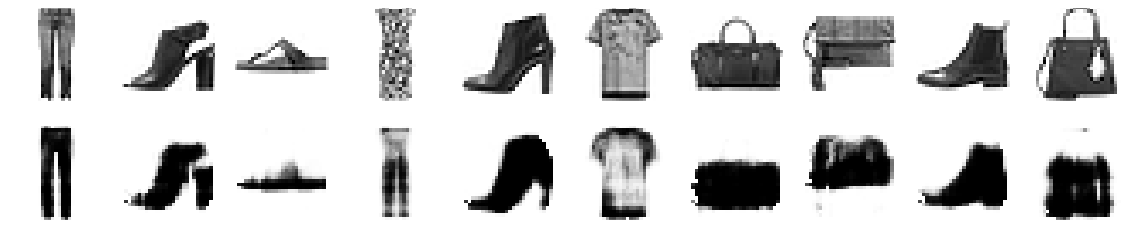

In [124]:
show_autoencoder_sample(encoder_24, decoder_24)

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 27us/sample - loss: 1.0351 - accuracy: 0.6925 - val_loss: 0.5735 - val_accuracy: 0.8036
Epoch 2/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.5275 - accuracy: 0.8156 - val_loss: 0.5093 - val_accuracy: 0.8263
Epoch 3/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4802 - accuracy: 0.8311 - val_loss: 0.4751 - val_accuracy: 0.8332
Epoch 4/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4578 - accuracy: 0.8374 - val_loss: 0.4568 - val_accuracy: 0.8404
Epoch 5/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4374 - accuracy: 0.8465 - val_loss: 0.4487 - val_accuracy: 0.8417
Epoch 6/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4254 - accuracy: 0.8503 - val_loss: 0.4479 - val_accuracy: 0.8438
Epoch 7/64
48000/48000 [===========

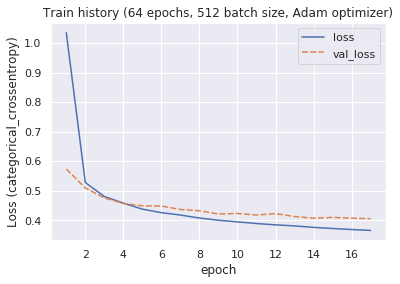

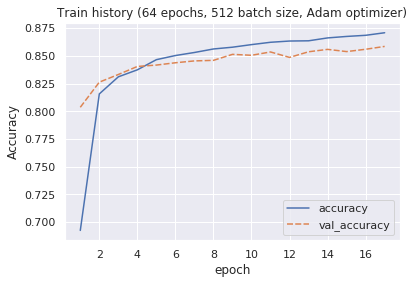

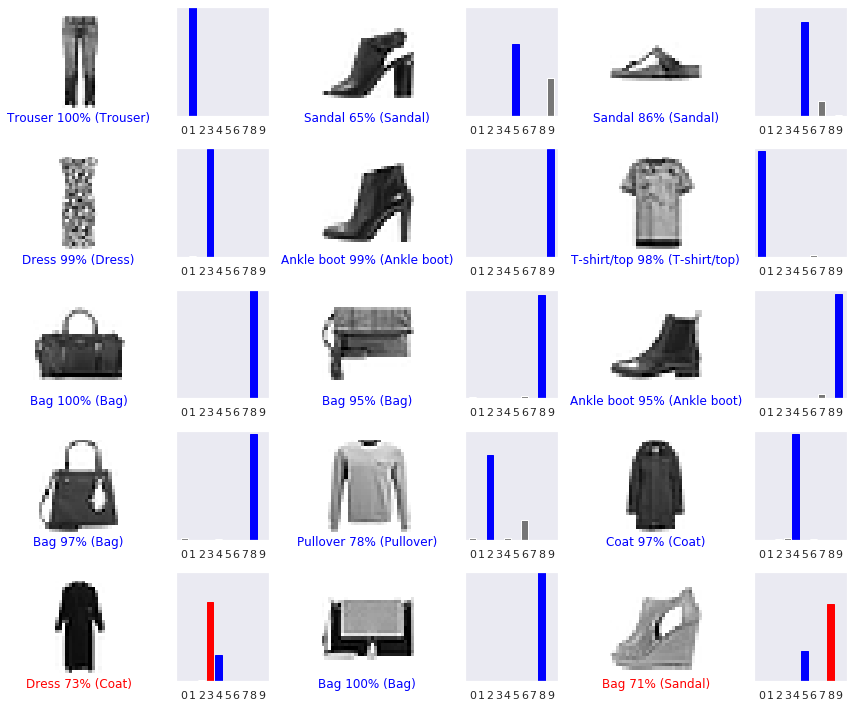

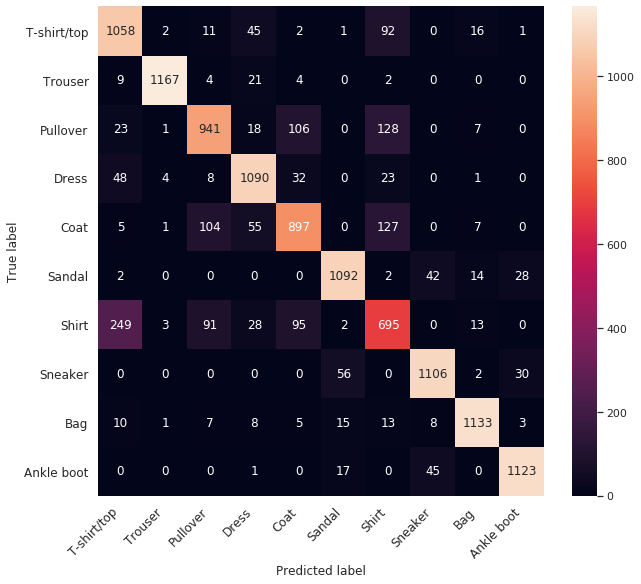

In [127]:
Y_val_ae_24_pred, model_ae_24 = train_ae_model(encoder_24, latent_dim, model_name="AE_24")

In [128]:
print_f1_scores(ys_val, np.argmax(Y_val_ae_24_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7536  |  0.8616  |  0.8040
Class 1 (Trouser):       0.9898  |  0.9669  |  0.9782
Class 2 (Pullover):      0.8070  |  0.7688  |  0.7874
Class 3 (Dress):         0.8610  |  0.9038  |  0.8819
Class 4 (Coat):          0.7862  |  0.7500  |  0.7677
Class 5 (Sandal):        0.9231  |  0.9254  |  0.9242
Class 6 (Shirt):         0.6423  |  0.5910  |  0.6156
Class 7 (Sneaker):       0.9209  |  0.9263  |  0.9236
Class 8 (Bag):           0.9497  |  0.9418  |  0.9457
Class 9 (Ankle boot):    0.9477  |  0.9469  |  0.9473

Combined F1 score:  0.8421
Combined Precision: 0.8443
Combined Recall:    0.8399


## 4. Using clustering techniques
Explore two clustering algorithms using the reduced features (PCA or Autoencoders). Do the clusters make sense? Check the validity/quality of your clusters.

In [0]:
from sklearn.cluster import KMeans, DBSCAN

In [0]:
def show_clusters(data, clusters):
    not_onehot = Y_val.argmax(axis=1)

    print( "Right:", np.count_nonzero((clusters.labels_ - not_onehot) == 0) )
    print( "Wrong:", np.count_nonzero((clusters.labels_ - not_onehot) != 0) )

    labels = clusters.labels_.astype(float)
    centroids = clusters.cluster_centers_

    xs = data[..., 0]
    ys = data[..., 1]

    # plt.figure()
    plt.scatter(
        x=xs, 
        y=ys,
        c=labels, 
        s=50, 
        alpha=0.8,
        cmap="viridis")
    plt.scatter(
        centroids[:, 0], 
        centroids[:, 1], 
        c='black',
        alpha=0.5,
        s=200,
        cmap="viridis")
    plt.show()

## KMeans

### Autoencoders

#### Latent vector size of 24

In [0]:
kmeans_autoencoder24 = KMeans(n_clusters=10).fit(Y_val_ae_24_pred)

Right: 25
Wrong: 11975


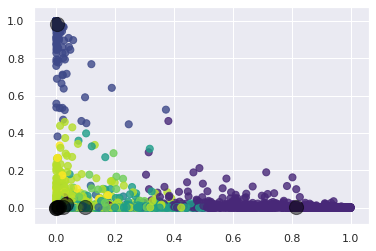

In [141]:
show_clusters(Y_val_ae_24_pred, kmeans_autoencoder24)

#### Latent vector size of 84

In [0]:
kmeans_autoencoder84 = KMeans(n_clusters=10).fit(Y_val_ae_84_pred)

Right: 26
Wrong: 11974


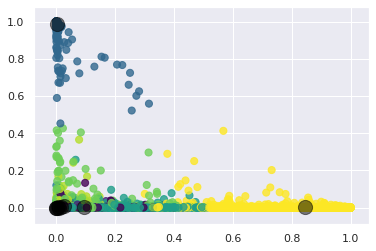

In [143]:
show_clusters(Y_val_ae_84_pred, kmeans_autoencoder84)

In [0]:
strftime('%X')

'22:39:42'